In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory

import gymnasium as gym
import mediapy as media
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

import wandb
from legato.nets import *
from legato.sampler import *

In [2]:
action_space_size = 1.0

In [3]:
def load_actor(run_path):
    temp_dir = TemporaryDirectory()
    for name in [
        "state_encoder.pt",
        "action_encoder.pt",
        "transition_model.pt",
        "state_decoder.pt",
        "action_decoder.pt",
        "indices.npz",
    ]:
        wandb.restore(
            f"trained_net_params/{name}",
            run_path=run_path,
            replace=True,
            root=temp_dir.name,
        )
        
    return temp_dir

In [4]:
actor_run_paths = {
    "Smoothness": "mishmish66/Legato/f9etzn17",
    "No Smoothness": "mishmish66/Legato/ka6f31tb",
}
actor_dirs = {name: load_actor(path) for name, path in actor_run_paths.items()}
actor_paths = {name: Path(dir.name) / "trained_net_params" for name, dir in actor_dirs.items()}

In [5]:
def test_actor(actor_dir):

    state_encoder = torch.load(actor_dir / "state_encoder.pt")
    action_encoder = torch.load(actor_dir / "action_encoder.pt")
    transition_model = torch.load(actor_dir / "transition_model.pt")
    state_decoder = torch.load(actor_dir / "state_decoder.pt")
    action_decoder = torch.load(actor_dir / "action_decoder.pt")
    indices = np.load(actor_dir / "indices.npz")

    actor = ActorPolicy(
        2,
        action_space_size,
        state_encoder,
        transition_model,
        state_decoder,
        action_decoder,
        optim_factory=torch.optim.SGD,
        # optim_factory=torch.optim.AdamW,
        # loss_func=custom,
        loss_func=torch.nn.L1Loss(reduction="none"),
        lr=16.0,
        decay=1.0,
        horizon=1024,
        iters=32,
        # tail_states=4,
        discount=0.99,
        temperature=0.0,
        samples=1,
        condensation_weight=100.0,
        silent=True
    ).cuda()

    # actor = torch.compile(actor)
    episode_len = 1024

    parallel_env_count = 128
    # Make parallel env
    envs = gym.vector.make(
        "PointMaze_Medium-v3",
        num_envs=parallel_env_count,
        asynchronous=False,
        render_mode="rgb_array",
        continuing_task=True,
        max_episode_steps=episode_len,
        reset_target=True,
    )

    obses, infos = envs.reset()
    states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")

    latent_action_plan = None

    skips = 4

    successes = []
    for i in tqdm(range(episode_len), desc="Testing Actor"):

        if i % skips == 0:
            target_states = torch.zeros(
                (parallel_env_count, 4), dtype=torch.float32, device="cuda"
            )
            desired_goals = torch.tensor(
                obses["desired_goal"], dtype=torch.float32, device="cuda"
            )
            target_states[:, :2] = desired_goals

            horizon_len = min(256, episode_len - i)
            horizons = torch.ones(parallel_env_count, device="cuda") * horizon_len
            next_actions, latent_action_plan, imagined, loss_curve = actor(
                # states, target_states, horizons, None, return_curve=True
                states,
                target_states,
                horizons,
                latent_action_plan,
                return_curve=True,
            )

        else:
            next_latent_act = latent_action_plan[..., 0, :]
            latent_action_plan = latent_action_plan[..., 1:, :]

            latent_states = state_encoder(states)
            next_actions = action_decoder((next_latent_act, latent_states)).detach()

        obses, rew, term, trunc, info = envs.step(next_actions.cpu().numpy())

        states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")

        successes.append(info["success"])

    success_counts = np.stack(successes, axis=1).sum(axis=1)

    return success_counts

In [6]:
success_counts_per_actor = {
    actor_name: test_actor(actor_path)
    for actor_name, actor_path in actor_paths.items()
}

/home/mishmish/Documents/venvs/legato_simple/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Testing Actor: 100%|██████████| 1024/1024 [02:49<00:00,  6.05it/s]
/home/mishmish/Documents/venvs/legato_simple/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Testing Actor: 100%|██████████| 1024/1024 [02:49<00:00,  6.04it/s]


In [19]:
df = pd.DataFrame.from_records(
    [
        (key, count, trial) for key, arr in success_counts_per_actor.items() for trial, count in enumerate(arr)
    ], columns=["Actor", "Successes", "Trial"]
)

In [29]:
df

,Actor,Successes,Trial
0,Smoothness,2,0
1,Smoothness,1,1
2,Smoothness,0,2
3,Smoothness,0,3
4,Smoothness,1,4
...,...,...,...
251,No Smoothness,0,123
252,No Smoothness,0,124
253,No Smoothness,0,125
254,No Smoothness,0,126


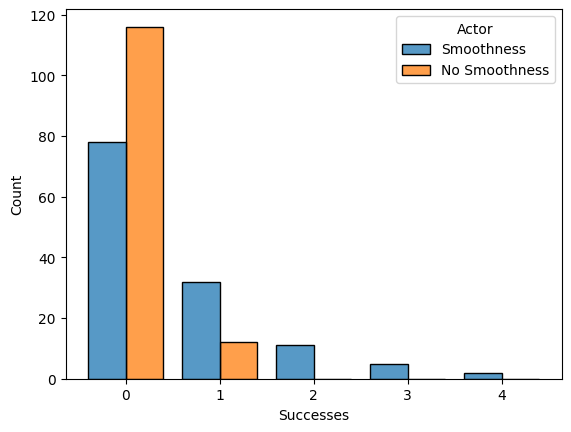

In [50]:
sns.histplot(
    data=df,
    x="Successes",
    hue="Actor",
    discrete=True,
    multiple="dodge",
    shrink=0.8,
)

plt.savefig("figures/smoothness_or_no.png")